In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from cone_prog_refine import *
import time
import numpy as np
import scipy.sparse as sp

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numba
import scipy
print('numpy version', np.version.full_version)
print('scipy version', scipy.__version__)
print('numba version', numba.__version__)

numpy version 1.15.1
scipy version 1.1.0
numba version 0.36.2


## Run experiments 

In [3]:
experiment_results = []

In [4]:
verbose = False

for i in range(1000):
    print('\n\nGenerating problem number %d..' % i)
    mode_choose = np.random.uniform(0,1)
    if mode_choose<.8:
        mode = 'solvable'
    if mode_choose>=.8 and mode_choose<.9:
        mode = 'infeasible'
    if mode_choose>=.9:
        mode = 'unbounded'
    A, b, c, dims, x_true, y_true, s_true = generate_problem(mode=mode)
    m,n = A.shape
    print('Cones:\t', dims)
    print('mode:\t', mode)
    print('(m,n):\t', A.shape)
    print('nnz(A):\t', A.nnz)
    start = time.time()
    if len(dims['s']) or dims['ep'] or dims['ed']:
        solver='scs'
        approx_z, info = scs_solve(A,b,c,dims,verbose=verbose)#, eps=1E-16)
    else:
        solver='ecos'
        try:
            approx_z, info = ecos_solve(A,b,c,dims, verbose=verbose)#, abstol=1E-16)
        except SolverError:
            continue
#     if solver == 'ecos' and info['exitFlag'] not in [0,10]:
#         continue ## not a solution
    solver_time =  time.time() - start
    if np.any(np.isnan(approx_z)):
        print('there are nans in the returned solution')
        continue
    print('solver:\t', solver)
    print('solver info:', info)
    print('solv. time:\t%.2f' % solver_time)
    res, u,v = residual_and_uv(approx_z, A,b,c, make_prod_cone_cache(dims))
    unrefined_resnorm = np.linalg.norm(res) / np.abs(approx_z[-1])
    #assert unrefined_resnorm < 1.
    print('||N(z_unref)||:\t%.2e' % unrefined_resnorm)
    #print('\ntau: %.2e\t kappa: %.2e' % (tau, kappa))
    x, s, y, tau, kappa = uv2xsytaukappa(u, v, n)
    assert (tau == 1. and kappa == 0) or (tau == 0 and kappa == 1)
    if tau == 1:
        #pri_res_norm, dua_res_norm, rel_gap, compl_gap = subopt_stats(A, b, c, x, s, y)
        print('||A@x + s - b|| = %.2e' % np.linalg.norm(A@x + s - b))
        print('||A.T@y + c || = %.2e' % np.linalg.norm(A.T@y + c ))
        #print('pri_res\tdua_res\trel_gap\t_compl_gap')
        #print('%.2e\t%.2e\t%.2e\t%.2e' % (pri_res_norm, dua_res_norm, rel_gap, compl_gap))
    
#     if unrefined_resnorm>1:
#         raise Exception

    #try:
    start = time.time()
    refined_z = refine(A,b,c, dims, approx_z, verbose=verbose)
    refine_time = time.time() - start
    print('ref. time:\t%.2f' % refine_time)
    res, u,v = residual_and_uv(refined_z,A,b,c,make_prod_cone_cache(dims))
    refined_resnorm = np.linalg.norm(res) / np.abs(refined_z[-1])
    print('||N(z_ref)||:\t%.2e' % refined_resnorm)
    #print('\ntau: %.2e\t kappa: %.2e' % (tau, kappa))
    x, s, y, tau, kappa = uv2xsytaukappa(u, v, n)
    assert (tau == 1. and kappa == 0) or (tau == 0 and kappa == 1)
    if tau == 1:
        #pri_res_norm, dua_res_norm, rel_gap, compl_gap = subopt_stats(A, b, c, x, s, y)
        #print('pri_res\tdua_res\trel_gap\t_compl_gap')
        #print('%.2e\t%.2e\t%.2e\t%.2e' % (pri_res_norm, dua_res_norm, rel_gap, compl_gap))
        print('||A@x + s - b|| = %.2e' % np.linalg.norm(A@x + s - b))
        print('||A.T@y + c || = %.2e' % np.linalg.norm(A.T@y + c ))
    #except Exception as e:
    #    print('Refinement failed:', e)
    #    continue


    experiment_results.append({'dims':dims, 
                               'Annz':A.nnz,
                               'm':A.shape[0],
                               'n':A.shape[1],
                               'solver':solver,
                               'solver_info':info,
                              'solver_time':solver_time,
                               'mode':mode,
                              'unrefined_resnorm':unrefined_resnorm,
                              'refine_time':refine_time,
                              'refined_resnorm':refined_resnorm})




Generating problem number 0..
Cones:	 {'z': 21, 'l': 93, 'q': [18, 15, 17, 18, 7, 10, 14, 9, 17, 16, 6, 11, 5, 18, 13, 5, 16, 10, 9, 10, 16, 9, 11, 11, 16, 8, 10, 12, 6, 16, 8, 11, 17, 15, 14, 11, 10, 16, 9, 12, 19, 14, 17, 11, 6, 9, 12, 17, 16, 16, 9, 14, 17, 11, 5, 16, 8, 12, 11, 16, 6, 14, 9, 17, 19], 's': [4, 8, 4, 6, 8, 8, 3, 8], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (1138, 570)
nnz(A):	 154517
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.6632325774840758, 'dobj': -0.663232030492402, 'resPri': 5.078783930851275e-07, 'resDual': 3.0852705137438424e-07, 'relGap': 2.3511712663450966e-07, 'resInfeas': nan, 'resUnbdd': 8.614089666350703, 'solveTime': 167.523952, 'setupTime': 5.100016, 'status': 'Solved'}
solv. time:	0.80
||N(z_unref)||:	7.33e-06
||A@x + s - b|| = 7.29e-06
||A.T@y + c || = 4.40e-07
ref. time:	1.77
||N(z_ref)||:	5.49e-06
||A@x + s - b|| = 5.03e-06
||A.T@y + c || = 1.41e-06


Generating problem number 1..
Cones:	 {'z': 28, 'l': 81, 'q': [19, 19, 

Cones:	 {'z': 19, 'l': 86, 'q': [15, 16, 14, 16, 19, 17, 13, 16, 5, 8, 10, 11, 8, 12, 14, 10, 12, 5, 7, 8, 15, 10, 14, 18, 8, 15, 14, 18, 11, 9, 10, 10, 8, 6, 18, 17, 14, 16, 10, 17, 10, 11, 5, 9, 12, 15, 6, 13, 17, 13, 13, 10, 12, 17, 9, 10, 19, 16, 8, 9, 12, 6, 19, 13, 19, 19], 's': [5, 7, 8, 3, 7, 7, 8, 5, 7, 4, 9, 3, 9], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1265, 554)
nnz(A):	 180084
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.13970144831692502, 'dobj': -0.13970283811281575, 'resPri': 1.187753741691766e-06, 'resDual': 8.719913273055983e-07, 'relGap': 1.0862835973537737e-06, 'resInfeas': nan, 'resUnbdd': 42.7730030399933, 'solveTime': 250.582216, 'setupTime': 4.886411, 'status': 'Solved'}
solv. time:	0.26
||N(z_unref)||:	2.54e-01
||A@x + s - b|| = 2.54e-01
||A.T@y + c || = 5.80e-03
ref. time:	0.19
||N(z_ref)||:	1.62e-01
||A@x + s - b|| = 1.45e-01
||A.T@y + c || = 2.50e-02


Generating problem number 9..
Cones:	 {'z': 14, 'l': 53, 'q': [13, 18, 14, 11, 11,

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.27058262689636775, 'dobj': -0.2705951681350829, 'resPri': 3.439749334825562e-06, 'resDual': 2.074559443342799e-06, 'relGap': 8.1374379747535e-06, 'resInfeas': nan, 'resUnbdd': 18.434918668816955, 'solveTime': 517.235472, 'setupTime': 2.685064, 'status': 'Solved'}
solv. time:	0.52
||N(z_unref)||:	4.36e-05
||A@x + s - b|| = 4.16e-05
||A.T@y + c || = 3.01e-06
ref. time:	0.21
||N(z_ref)||:	3.37e-05
||A@x + s - b|| = 3.27e-05
||A.T@y + c || = 4.84e-06


Generating problem number 17..
Cones:	 {'z': 23, 'l': 87, 'q': [6, 6, 5, 10, 8, 9, 10, 10, 18, 17, 15, 5, 17, 14, 6, 7, 14, 10, 13, 18, 15, 5, 19, 15, 6, 8, 14, 7, 18, 7, 10, 11, 6, 8, 13, 7, 16, 13, 18, 7, 6, 13, 19, 11, 11, 13, 12, 15, 7, 7, 16, 5, 8], 's': [2, 7, 3, 8, 4, 7, 6, 4, 6, 2, 5], 'ep': 3, 'ed': 4}
mode:	 solvable
(m,n):	 (896, 462)
nnz(A):	 82993
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.002525349991074089, 'dobj': -0.002519907491348364, 

/Users/enzo/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Cones:	 {'z': 19, 'l': 56, 'q': [6, 11, 16, 7, 18, 15, 13, 11, 8, 9, 11, 10, 16, 15, 9, 10, 15, 12, 12, 15, 6, 6, 8, 15, 19, 17, 6, 10, 8, 11, 17, 5, 19, 16, 9, 5, 18, 17, 16, 14, 5, 16, 19, 15, 6, 15, 8, 14, 8, 11, 16, 16, 18, 15, 13, 6, 7, 19, 19, 19, 13, 12, 18, 8, 13, 16, 6, 19, 11, 12, 8, 7, 10, 6, 14, 17, 18, 15, 6, 6, 9, 8, 16, 8, 13, 13, 7, 11, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (1148, 2)
nnz(A):	 1250
dual infeas. cert residual norm 2.9362172365573624e-08
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -26375323148.234833, 'dcost': -19414389325.60133, 'pres': 0.8319453934823604, 'dres': 0.5290310774477499, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': nan, 'dinfres': 1.3637948238839036e-09, 'gap': 4.165054749982744e-06, 'relgap': 1.5791483298893686e-16, 'r0': 1e-08, 'iter': 6, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.003224314, 'tsetup': 0.000641219, 'tsolve': 0.002583095}, 'numerr': 0}
solv. ti

ref. time:	0.12
||N(z_ref)||:	1.05e-06
||A@x + s - b|| = 9.88e-07
||A.T@y + c || = 2.66e-07


Generating problem number 28..
Cones:	 {'z': 42, 'l': 70, 'q': [9, 8, 10, 6, 8, 10, 13, 5, 8, 15, 13, 17, 14, 7, 19, 16, 16, 18, 11, 12, 12, 10, 7, 12, 11, 16, 8, 17, 13, 17, 16, 18, 8, 17, 13, 14, 5, 12, 10, 7, 7, 10, 8, 18, 12, 15, 6, 8, 8, 10, 11, 15, 8, 11, 8, 14, 11, 17, 13, 5, 17, 10, 9], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (841, 738)
nnz(A):	 172952
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': 0.32720743484488896, 'dcost': 0.3272073532856226, 'pres': 3.8196804819340754e-11, 'dres': 1.2463653982059367e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.9232383534609201, 'dinfres': nan, 'gap': 6.972378022163106e-08, 'relgap': 2.1308744904876408e-07, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 24.813549226, 'tsetup': 0.13861469, 'tsolve': 24.674934536}, 'numerr': 0}
solv. time:	24.82
||N(z_unref)||:	1.32e-05

Cones:	 {'z': 42, 'l': 56, 'q': [10, 15, 14, 13, 13, 5, 6, 8, 17, 12, 17, 14, 5, 8, 14, 7, 17, 7, 15, 9, 18, 7, 16, 13, 17, 9, 14, 12, 8, 7, 10, 7, 12], 's': [8, 8, 7, 2, 3, 2, 6, 8, 5, 8, 9, 2, 4, 5, 8, 7, 8, 5], 'ep': 3, 'ed': 4}
mode:	 solvable
(m,n):	 (903, 401)
nnz(A):	 102279
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.24618377384230852, 'dobj': 0.2461927196375892, 'resPri': 5.372908560947583e-07, 'resDual': 2.9051865718173874e-07, 'relGap': 5.994328723193161e-06, 'resInfeas': 22.462101865631684, 'resUnbdd': nan, 'solveTime': 170.907482, 'setupTime': 1.442381, 'status': 'Solved'}
solv. time:	0.17
||N(z_unref)||:	1.14e-05
||A@x + s - b|| = 7.10e-06
||A.T@y + c || = 4.22e-07
ref. time:	0.16
||N(z_ref)||:	5.96e-06
||A@x + s - b|| = 5.53e-06
||A.T@y + c || = 1.30e-06


Generating problem number 38..
Cones:	 {'z': 10, 'l': 98, 'q': [14, 15, 16, 15, 16, 18, 19, 6, 5, 14, 18, 9, 12, 10, 16, 8, 10, 6, 7, 7, 5, 18, 14, 11, 16, 18, 11, 6, 18, 9, 19, 6, 12, 16, 10, 15, 

prim abs res. 1.1302397239161564e-11
dua abs res. 2.7413420359794995e-12
s^T y 3.11362491345335e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.2170090203539772, 'dcost': -0.21700902060376784, 'pres': 1.637516101886179e-13, 'dres': 2.5600876389600236e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 2.1973044324813467, 'gap': 4.596251990118816e-10, 'relgap': 2.118000432710851e-09, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 2.72074105, 'tsetup': 0.141374497, 'tsolve': 2.579366553}, 'numerr': 0}
solv. time:	2.73
||N(z_unref)||:	9.29e-07
||A@x + s - b|| = 9.29e-07
||A.T@y + c || = 2.73e-08
ref. time:	0.27
||N(z_ref)||:	1.02e-07
||A@x + s - b|| = 7.46e-08
||A.T@y + c || = 6.72e-08


Generating problem number 47..
Cones:	 {'z': 24, 'l': 42, 'q': [14, 14, 8, 15, 16, 10, 19, 17, 15, 8, 18, 10, 15, 7, 12, 7, 18, 9, 15, 10, 10, 12, 9, 6, 18, 8, 15, 10, 11, 7, 7, 6, 15, 6, 8, 6, 7, 19, 18, 7, 16, 11, 18, 5, 17, 8, 14, 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.22626488904976222, 'dobj': -0.22627174214306403, 'resPri': 8.016449945881568e-07, 'resDual': 4.202997661107168e-07, 'relGap': 4.7180175388651335e-06, 'resInfeas': nan, 'resUnbdd': 27.084217529629004, 'solveTime': 208.81988, 'setupTime': 5.341879, 'status': 'Solved'}
solv. time:	0.22
||N(z_unref)||:	1.45e-05
||A@x + s - b|| = 1.28e-05
||A.T@y + c || = 5.92e-07
ref. time:	0.20
||N(z_ref)||:	1.01e-05
||A@x + s - b|| = 9.67e-06
||A.T@y + c || = 2.15e-06


Generating problem number 55..
Cones:	 {'z': 10, 'l': 45, 'q': [15, 7, 6, 13, 16, 5, 19, 18, 12, 10, 10, 14, 15, 9, 14, 7, 7, 13, 16, 8, 9, 6, 8, 16, 6, 13, 18, 19, 6, 19, 9, 16, 6, 7, 8, 5, 16, 8, 19, 17, 17, 12, 18, 10, 9, 11, 16, 7, 15, 9, 7, 8, 12, 12, 5, 18, 12, 14, 5, 15, 19, 13, 12, 16, 15, 18, 8, 14, 14, 9, 11, 9, 18, 8, 18, 8, 19, 14, 5, 13, 13], 's': [2, 3, 2, 2, 3, 5, 3, 8, 8, 2, 9, 8], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1260, 529)
nnz(A):	 174925
solver:

ref. time:	0.16
||N(z_ref)||:	5.14e-06
||A@x + s - b|| = 4.68e-06
||A.T@y + c || = 1.83e-06


Generating problem number 64..
Cones:	 {'z': 14, 'l': 22, 'q': [12, 8, 6, 19, 18, 16, 18, 15, 13, 17, 17, 13, 6, 19, 11, 13, 19, 7, 12, 13, 19, 7, 11, 6, 13, 5, 5, 16, 18, 6, 7, 13, 9, 9, 15, 8, 10, 7, 18, 6, 10, 11, 17, 15, 9, 19, 9, 16, 7, 17, 6, 9, 19, 17, 11, 16, 9, 12, 15, 19, 13, 12, 18, 10, 11, 11, 5, 8, 12, 17, 10, 14, 18, 11, 6, 9, 19, 8, 12, 19, 6, 10, 9, 9, 15, 17], 's': [6, 3, 8, 5, 5, 3, 4, 7, 8, 2, 3, 8, 2, 3, 7, 9, 3, 4, 9], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (1479, 534)
nnz(A):	 253719
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.14238243852691604, 'dobj': 0.14238187442649727, 'resPri': 7.970686740617072e-08, 'resDual': 4.532139110056971e-08, 'relGap': 4.390691841901626e-07, 'resInfeas': 43.92354050557621, 'resUnbdd': nan, 'solveTime': 488.563369, 'setupTime': 8.228827, 'status': 'Solved'}
solv. time:	0.50
||N(z_unref)||:	1.46e-06
||A@x + s - b|| = 1.

solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': 0.29789459715154104, 'dobj': 0.2978815608329892, 'resPri': 1.9483137874745292e-06, 'resDual': 1.264970635874628e-08, 'relGap': 8.169265148241573e-06, 'resInfeas': 21.86337627786046, 'resUnbdd': nan, 'solveTime': 1791.750643, 'setupTime': 11.996843, 'status': 'Solved'}
solv. time:	1.81
||N(z_unref)||:	3.65e-05
||A@x + s - b|| = 3.41e-05
||A.T@y + c || = 1.77e-08
ref. time:	0.41
||N(z_ref)||:	2.58e-05
||A@x + s - b|| = 2.20e-05
||A.T@y + c || = 5.39e-06


Generating problem number 73..
Cones:	 {'z': 33, 'l': 92, 'q': [6, 15, 12, 13, 10, 17, 10, 13, 19, 9, 14, 19, 18, 19, 9, 5, 18, 19, 13, 11, 13, 9, 16, 16], 's': [2, 3, 4, 5, 2, 4, 3, 3, 6, 4, 8, 2, 4], 'ep': 5, 'ed': 8}
mode:	 solvable
(m,n):	 (626, 51)
nnz(A):	 12028
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.04366934651082272, 'dobj': -0.043666783409635014, 'resPri': 2.691196499143442e-07, 'resDual': 1.8516699645432027e-07, 'relGap': 2.3572298548523

LinAlgError: Array must not contain infs or NaNs.

In [ ]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

EPS = 1E-16  ##machine precision
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(10,8))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  c = timeratio, 
                  alpha=.5, 
                  cmap='magma'
                 )
cbar = fig.colorbar(col, shrink=.85)#, 
                   # ticks=[-3, -2, -1 , 0])
#cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$'])


cbar.ax.set_ylabel('log_10 ( ref. time / solver time )')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5)#,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
#left.legend(loc='upper left')
left.set_xlim([EPS, 10.])
left.set_ylim([EPS, 10.])

# right.set_xscale('log')
# right.set_yscale('log')
# right.scatter( [ el['solver_time']  for el in experiment_results],
# [el['refine_time'] for el in experiment_results])
# right.set_xlim([0.001,10])
# right.set_ylim([0.001,10])
# right.plot([0.001,10],[0.001,10], 'k--' , alpha= .5,label='refinement boundary')
# right.set_xlabel('solver time (s)')
# right.set_ylabel('refinement time (s)')

plt.savefig('comparison.png')

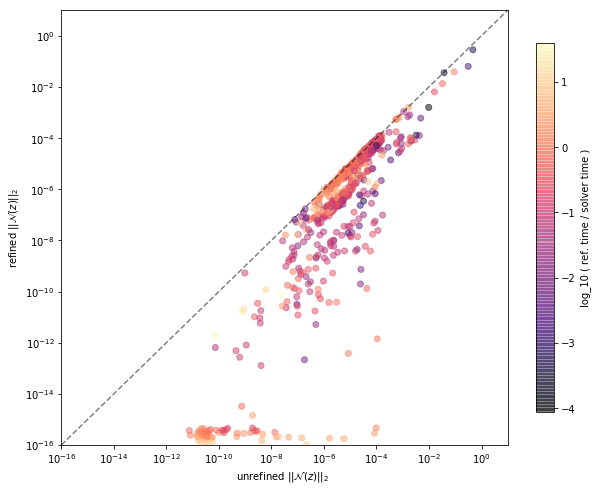

In [30]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

EPS = 1E-16  ##machine precision
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(10,8))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  c = timeratio, 
                  alpha=.5, 
                  cmap='magma'
                 )
cbar = fig.colorbar(col, shrink=.85)#, 
                   # ticks=[-3, -2, -1 , 0])
#cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$'])


cbar.ax.set_ylabel('log_10 ( ref. time / solver time )')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5)#,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
#left.legend(loc='upper left')
left.set_xlim([EPS, 10.])
left.set_ylim([EPS, 10.])

# right.set_xscale('log')
# right.set_yscale('log')
# right.scatter( [ el['solver_time']  for el in experiment_results],
# [el['refine_time'] for el in experiment_results])
# right.set_xlim([0.001,10])
# right.set_ylim([0.001,10])
# right.plot([0.001,10],[0.001,10], 'k--' , alpha= .5,label='refinement boundary')
# right.set_xlabel('solver time (s)')
# right.set_ylabel('refinement time (s)')

plt.savefig('comparison.png')

Text(0.5,0,'refined $\\||\\mathcal{N}(z) \\||_2$ / unrefined $\\||\\mathcal{N}(z) \\||_2$ ')

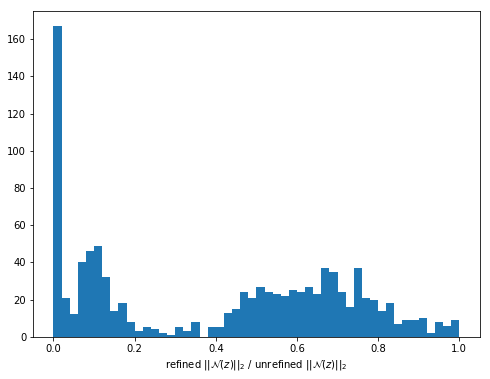

In [50]:
plt.figure(figsize=(8,6))
plt.hist(refined_Nzs / unrefined_Nzs, bins = 50)
plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

Text(0.5,0,'refined $\\||\\mathcal{N}(z) \\||_2$ / unrefined $\\||\\mathcal{N}(z) \\||_2$ ')

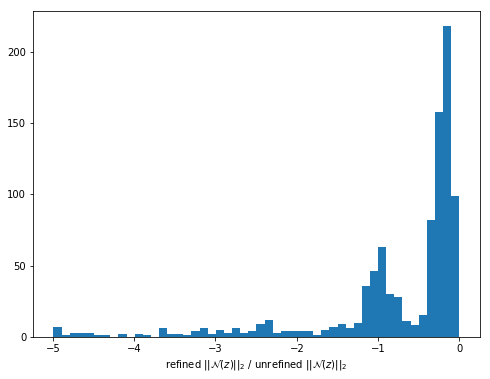

In [52]:
plt.figure(figsize=(8,6))

samples = np.log10(refined_Nzs / unrefined_Nzs)

samples = samples[samples>-5]
plt.hist(samples, bins = 50)
plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

#### Ranges of n and m 

In [23]:
n_s = np.array([el['n'] for el in experiment_results])
m_s = np.array([el['m'] for el in experiment_results])

(array([ 35.,  68., 128., 161., 179., 150., 143.,  88.,  29.,  17.]),
 array([ 284. ,  439.8,  595.6,  751.4,  907.2, 1063. , 1218.8, 1374.6,
        1530.4, 1686.2, 1842. ]),
 <a list of 10 Patch objects>)

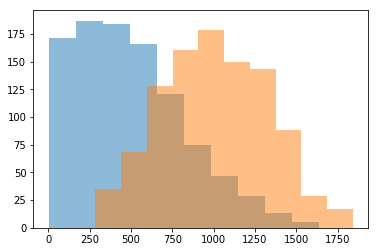

In [26]:
plt.hist(n_s, alpha=.5),
plt.hist(m_s, alpha=.5)

In [29]:
(np.quantile(n_s, .1), np.quantile(n_s, .9)), (np.quantile(m_s, .1), np.quantile(m_s, .9))

((98.0, 961.3000000000001), (587.4, 1420.3000000000002))

#### Alternate plot 

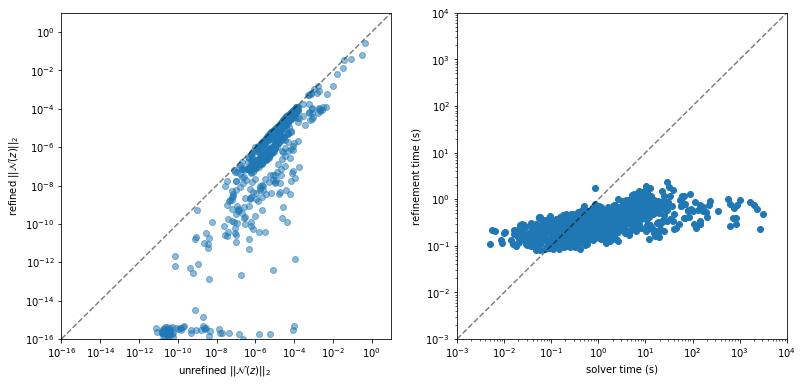

In [19]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, (left,right) = plt.subplots(1,2,figsize=(13,6))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  #c = timeratio, 
                  alpha=.5, 
                  #cmap='seismic'
                 )
# cbar = plt.colorbar(col, shrink=.85, 
#                     ticks=[-2, -1 , 0])
# cbar.ax.set_yticklabels(['$10^{-2}$', '$10^{-1}$' , '$10^0$'])


# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5)#,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
#left.legend(loc='upper left')
left.set_xlim([EPS, 10.])
left.set_ylim([EPS, 10.])

right.set_xscale('log')
right.set_yscale('log')
right.scatter( [ el['solver_time']  for el in experiment_results],
[el['refine_time'] for el in experiment_results])
right.set_xlim([0.001,10000])
right.set_ylim([0.001,10000])
right.plot([0.001,10000],[0.001,10000], 'k--' , alpha= .5,label='refinement boundary')
right.set_xlabel('solver time (s)')
right.set_ylabel('refinement time (s)')




plt.savefig('comparison.png')

#### Ranges of refinement and solver times

In [31]:
soltime = [ el['solver_time']  for el in experiment_results]
reftime = [ el['refine_time']  for el in experiment_results]

(np.quantile(soltime, .1), np.quantile(soltime, .9)), (np.quantile(reftime, .1), np.quantile(reftime, .9))

((0.08795013427734374, 12.540558242797857),
 (0.14479057788848876, 0.6941631555557252))

(-4, 2)

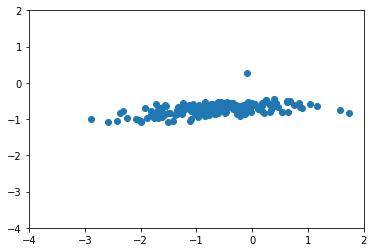

In [16]:
plt.scatter( 
            np.log10([ el['solver_time']  for el in experiment_results]),
np.log10([el['refine_time'] for el in experiment_results]))
plt.xlim([-4,2])
plt.ylim([-4,2])

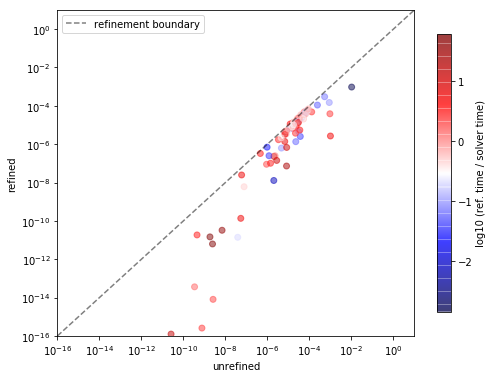

In [6]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

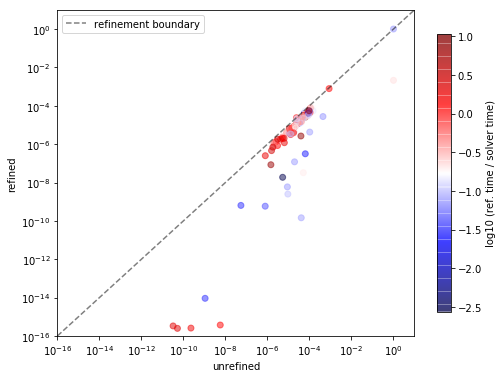

In [6]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

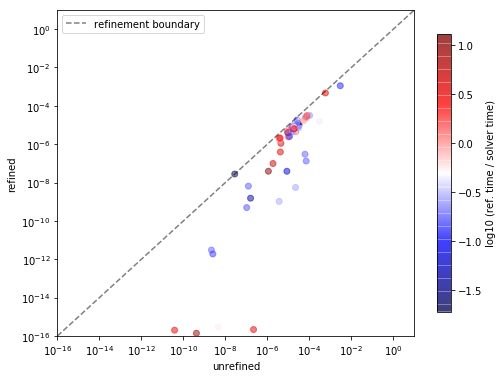

In [7]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

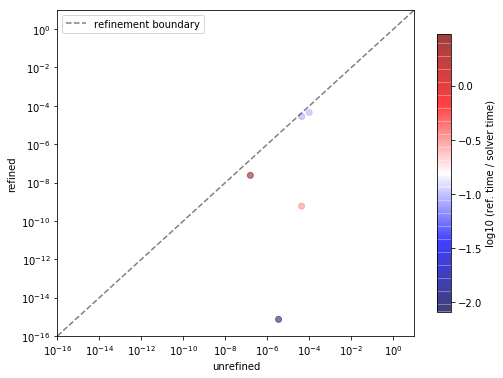

In [7]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

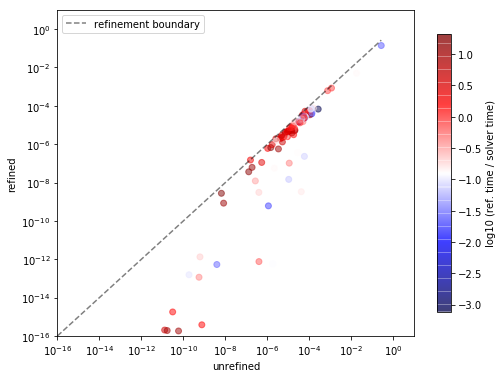

In [5]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,maxval],[EPS,maxval], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

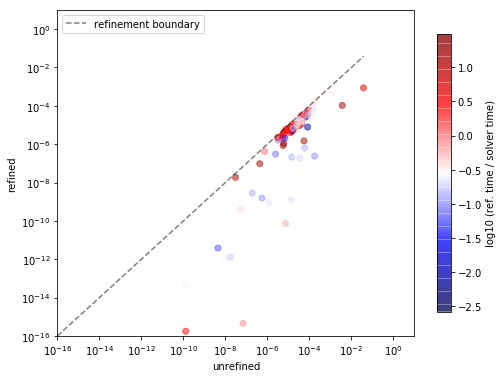

In [5]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,maxval],[EPS,maxval], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

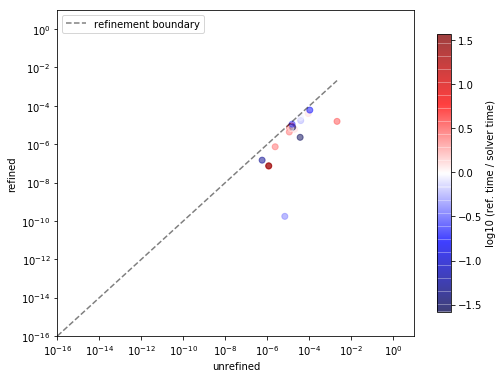

In [5]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,maxval],[EPS,maxval], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])


plt.savefig('comparison.png')

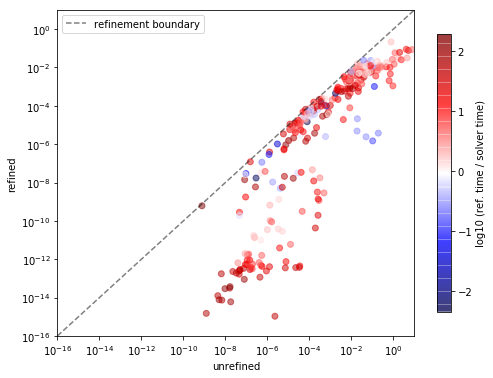

In [7]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,maxval],[EPS,maxval], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])


plt.savefig('comparison.png')

## Paper plot 

In [116]:
plt.colorbar?

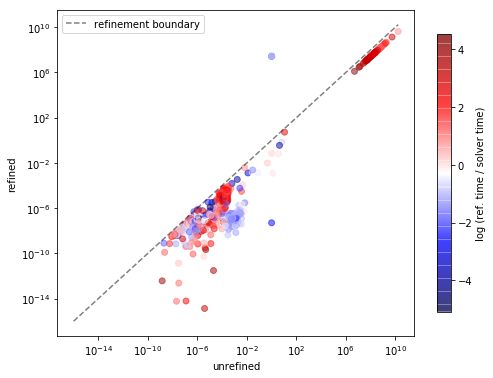

In [124]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,maxval],[EPS,maxval], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


plt.savefig('comparison.png')

## Interactive plot 

In [61]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [62]:
output_notebook()


Loading BokehJS ...

In [90]:
import pandas as pd
results = pd.DataFrame(data=experiment_results)
results['unrefined_logresnorm'] = np.log10(results['unrefined_resnorm'])
results['refined_logresnorm'] = np.log10(results['refined_resnorm'])

In [91]:
p1 = figure()
p1.scatter(results['unrefined_logresnorm'], results['refined_logresnorm'] )
p1.

#p1.line([EPS, maxval], [EPS, maxval], line_width=2)


show(p1)

In [89]:
# def generate_dim_dict(nonneg_num_min=0,
#                       nonneg_num_max=100,
#                       lorentz_num_min=0,
#                       lorentz_num_max=10,
#                       lorentz_size_min=1,
#                       lorentz_size_max=20,
#                       semidef_num_min=0,
#                       semidef_num_max=10,
#                       semidef_size_min=1,
#                       semidef_size_max=20,
#                       exp_num_min=0,
#                       exp_num_max=10):
#     result = {}
#     result['l'] = int(np.random.uniform(nonneg_num_min,
#                                         nonneg_num_max))
#     num_q = int(np.random.uniform(lorentz_num_min,
#                                   lorentz_num_max))
#     result['q'] = [int(np.random.uniform(lorentz_size_min,
#                                          lorentz_size_max))
#                    for i in range(num_q)]
#     num_s = int(np.random.uniform(semidef_num_min,
#                                   semidef_num_max))
#     result['s'] = [int(np.random.uniform(semidef_size_min,
#                                          semidef_size_max))
#                    for i in range(num_s)]
#     result['ep'] = int(np.random.uniform(exp_num_min,
#                                          exp_num_max))
#     return result

In [2]:
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


In [3]:
# np.random.seed(0)
# dim_dict = {'l':100, 's':[20]*3,
#             #'ep':20, 'ed':20, 
#             'q':[20]*10}

# A, b, c, x_true, s_true, y_true = generate_problem(dim_dict, density=.3, random_scale_max=2.)

# m,n = A.shape

# #print(m,n)
# #z_true = np.concatenate([x_true, -s_true + y_true, [1.]])

# z = np.ones(m+n+1)

# for i in range(100):
#     z = refine(A,b,c, dim2cones(dim_dict), 
#                z,
#               iters=10,
#               lsqr_iters=i * 10)
# # for i in range(1):
# #     z = refine(A,b,c, dim2cones(dim_dict), z, max_runtime=10)

# # x,s,y,info = solve(A, b, c, dim_dict, verbose=True, 
# #           #solver='scs', solver_options={'eps':1E-16, 'max_iters':500},
# #      solver='ecos', solver_options={'feastol':1e-16, 'reltol':1e-16, 'abstol':1e-16},#, 'max_iters':20}, 
# #         refine_solver_time_ratio=1.,
# #          )
# #solver_options={'eps':1e-16})

# x, s, y = z2xsy(z, n, dim2cones(dim_dict))

# np.linalg.norm(A@x + s - b) / (1+np.linalg.norm(b)), \
# np.linalg.norm(A.T@y + c) / (1+np.linalg.norm(c)),\
# np.abs(c@x + b@y) /  (1 + np.abs(c@x) + np.abs(b@y))

In [7]:
def subopt_metric(z, res):
    return np.linalg.norm(res) #/ (1. + np.linalg.norm(z))

def compare(dim_dict, scs_presolve_iters = 1000, scs_presolve_eps = 1e-16, max_lsqr_iters=100,
            conico_scs_time_ratio = 1., verbose=True, **generate_opts):
        
    A, b, c, x_true, s_true, y_true = generate_problem(dim_dict, **generate_opts)

    scs_opts = {'verbose':verbose}
    if scs_presolve_eps is not None:
        scs_opts['eps'] = scs_presolve_eps
    if scs_presolve_iters is not None:
        scs_opts['max_iters'] = scs_presolve_iters

    start = time.time()
    z_con, info = solve(A,b,c,dim_dict, verbose=verbose,
                              max_lsqr_iters=max_lsqr_iters,
                              refine_solver_time_ratio=conico_scs_time_ratio,
                             solver_options=scs_opts, return_z=True)
    #print(info)
    conico_time = time.time() - start
    #u,v = xsy2uv(x_con, s_con, y_con)
    res, u,v, _ = residual_and_uv(z_con,A,b,c,dim2cones(dim_dict))

    conico_subopt = subopt_metric(z_con, res)

    k = info['iter']
    scs_subopt = None

    while k < 25000:

        k *= 2
        start = time.time()
        z_scs, info = scs_solve(A, b, c, dim_dict, verbose=False, max_iters = k, eps=1e-16)
        scs_time = time.time() - start

        res, u,v, _ = residual_and_uv(z_scs,A,b,c,dim2cones(dim_dict))

        if scs_subopt is None:
            scs_subopt = subopt_metric(z_scs, res)
        else:
            scs_subopt = min(scs_subopt, subopt_metric(z_scs, res))

        if scs_time > conico_time:
            break
    if conico_time > scs_time:
        return np.nan, np.nan, conico_time, scs_time

    assert scs_time > conico_time
    
    return conico_subopt, scs_subopt, conico_time, scs_time

In [8]:
# np.random.seed(0)
# dims = {'l':10, 's':[20]*5}
# A,b,c,x,y,s = generate_problem(dims, random_scale_max=2000, mode='solvable')
# solve(A, b, c, dims, solver_options={'max_iters':500}, verbose=True, return_z = True)

In [9]:
N_repeats = 10

long_scs_run = 5000
short_scs_run = 1000

small_eps = 1e-16#1e-11 

large_scale = 40
medium_scale = 10
small_scale = 2


experiments = [
    ## dims, options
    
    # exp
    
    #[{'l':10, 'ep':100}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
     #                        'mode':'solvable', 'nondiff_point':False, 'density':.3, 'random_scale_max':medium_scale}],
    
    # socp
#     [{'l':10, 'q':[30]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
#                              'mode':'solvable', 'nondiff_point':False, 'density':.3, 'random_scale_max':medium_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'solvable', 'nondiff_point':False, 'density':.3, 'random_scale_max':medium_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':medium_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':large_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':large_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':small_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run*3, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':small_scale}],
    
    # sdp
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':medium_scale}],
#     [{'l':100, 's':[30]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
#                              'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':medium_scale}],
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':medium_scale}],
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':large_scale}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':large_scale}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':small_scale}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':small_scale}],
    
    # infeas/unbound
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':large_scale}],
    #[{'l':10, 'q':[10]*20}, {'scs_presolve_iters':short_scs_run*2, 'scs_presolve_eps':small_eps,
    #                     'mode':'unbounded', 'nondiff_point':False, 'density':.2, 'random_scale_max':small_scale}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':small_eps,
                         'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':small_scale}],
    [{'l':10, 's':[5]*5}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'unbounded', 'nondiff_point':False, 'density':.3, 'random_scale_max':large_scale}],
    [{'l':10, 'q':[5]*5, 's':[5]*5}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
                             'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':medium_scale}],
    
    
]

In [10]:
# experiments = \
#  [
# [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':small_eps,
#                          'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':large_scale}],
#  ]

## Run all experiments 

In [11]:
con_subopts, scs_subopts = [], []

In [12]:
np.random.seed(10)

for experiment in experiments:
    print(experiment)
    for i in range(N_repeats):
        con_subopt, scs_subopt, conico_time, scs_time = compare(experiment[0], 
#                                                             scs_presolve_iters = 5000,
#                                                             scs_presolve_eps = 1e-11,
                                                            verbose=False,
                                                            **experiment[1])
        con_subopts.append(con_subopt)
        scs_subopts.append(scs_subopt)
        print('%.2e, %.2e, %.2f, %.2f' % (con_subopt, scs_subopt, conico_time, scs_time))
    print()

[{'l': 10, 'q': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}, {'scs_presolve_iters': 5000, 'scs_presolve_eps': 1e-16, 'mode': 'solvable', 'nondiff_point': False, 'density': 0.3, 'random_scale_max': 10}]


TypeError: generate_problem() got an unexpected keyword argument 'nondiff_point'

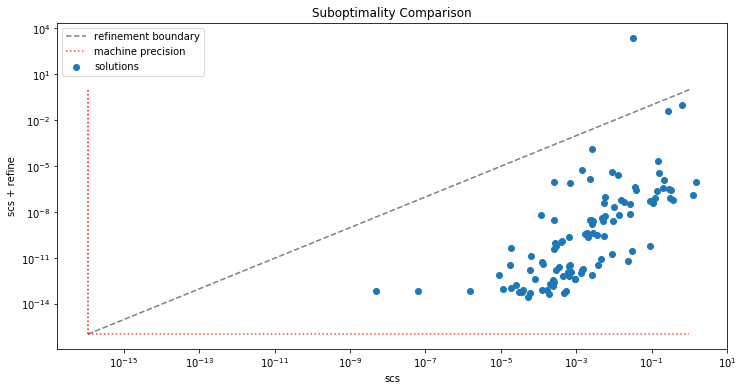

In [10]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

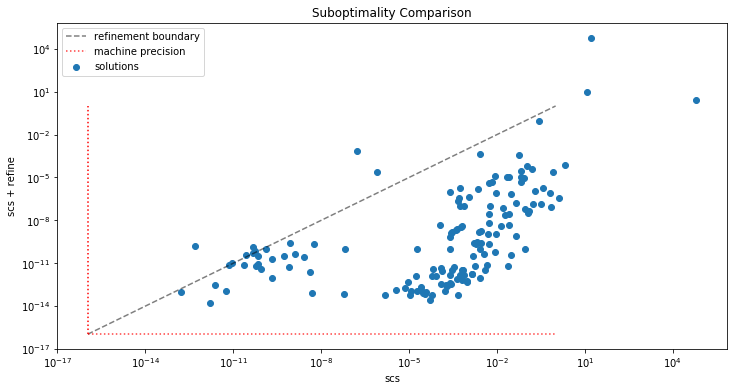

In [18]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

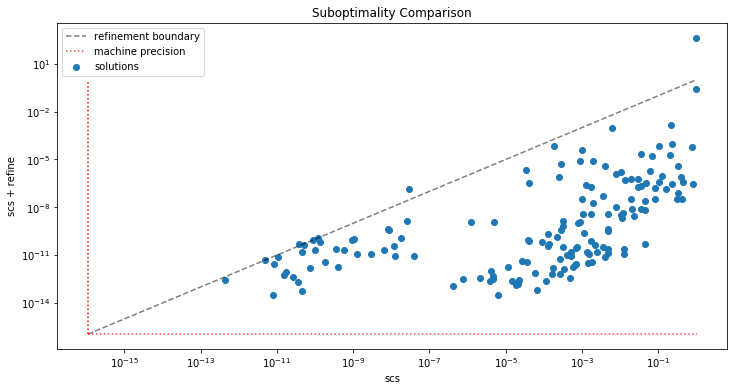

In [11]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

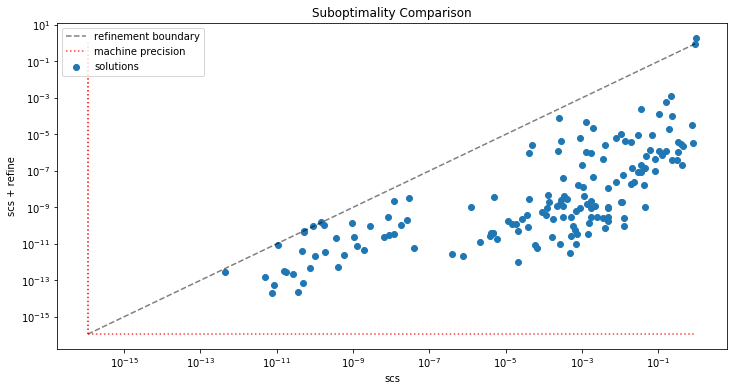

In [11]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

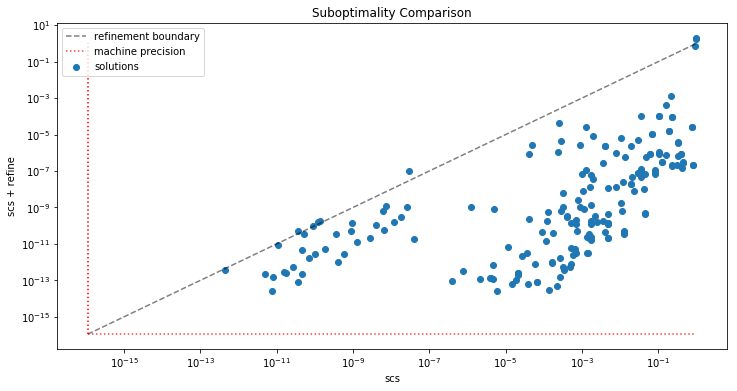

In [12]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

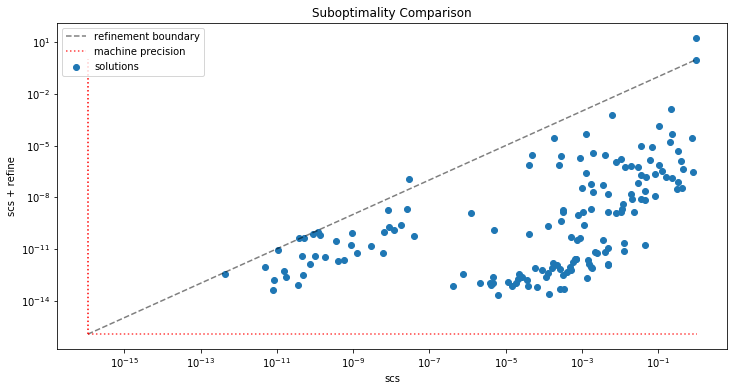

In [9]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

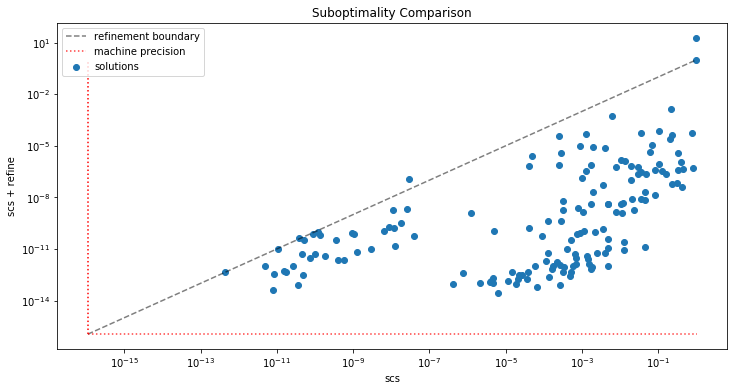

In [10]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

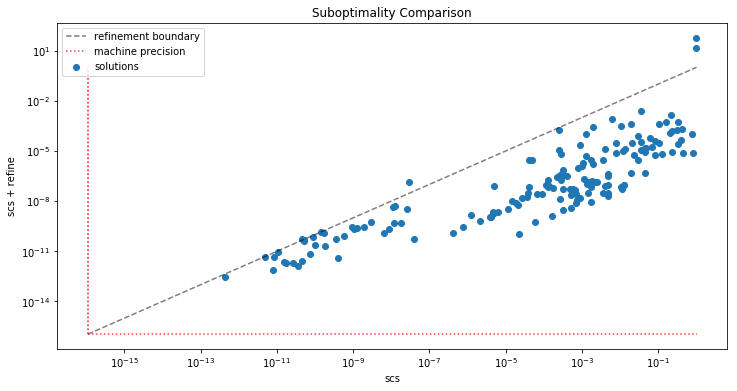

In [9]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

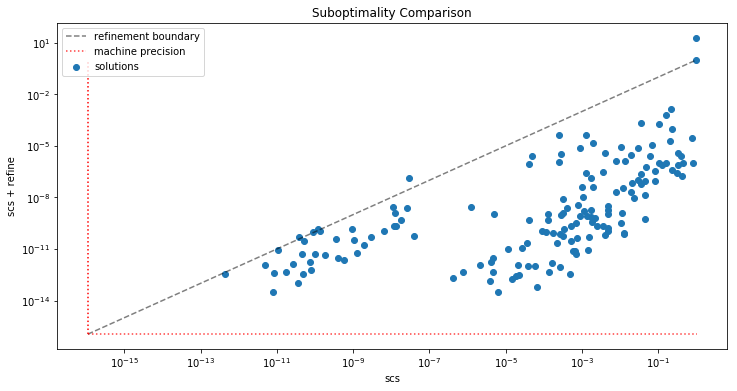

In [9]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

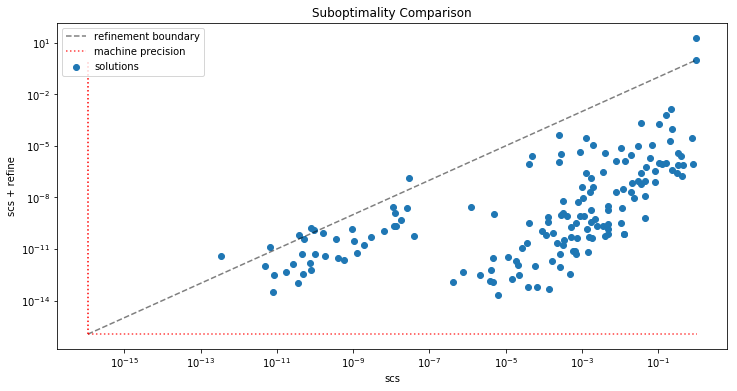

In [74]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
# plt.xlim([EPS/10, 10.])
# plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

(1.1102230246251566e-17, 10.0)

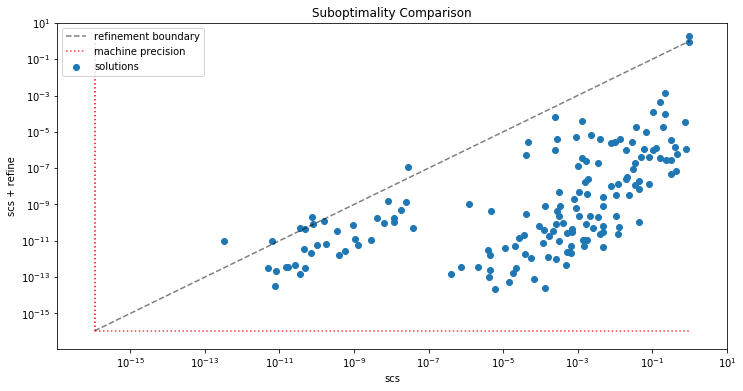

In [19]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS/10, 10.])
plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

(1.1102230246251566e-17, 10.0)

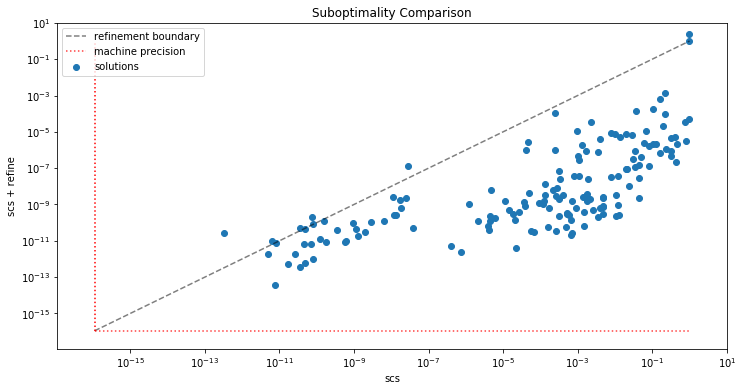

In [13]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS/10, 10.])
plt.ylim([EPS/10, 10.])


#plt.savefig('comparison.png')

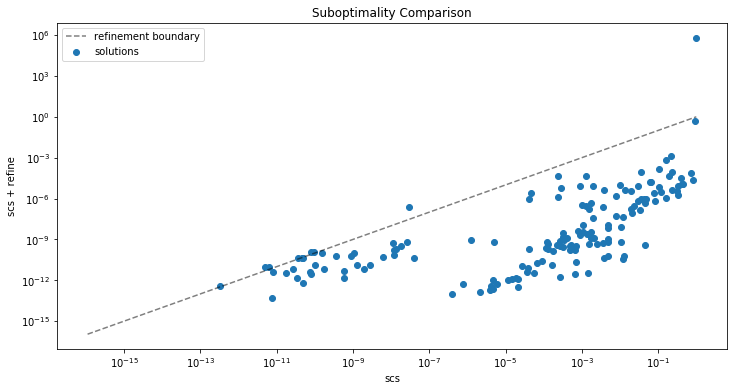

In [35]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

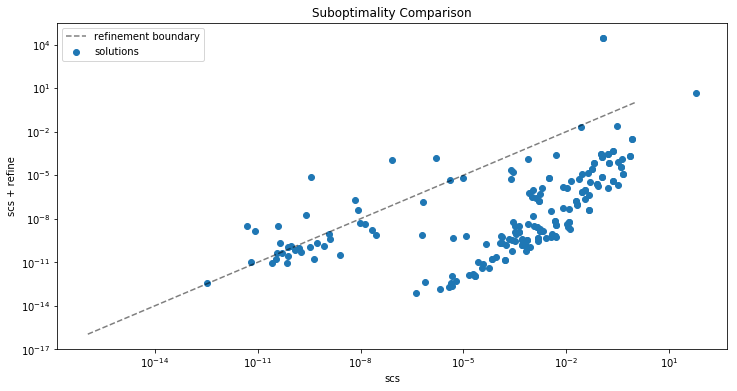

In [16]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

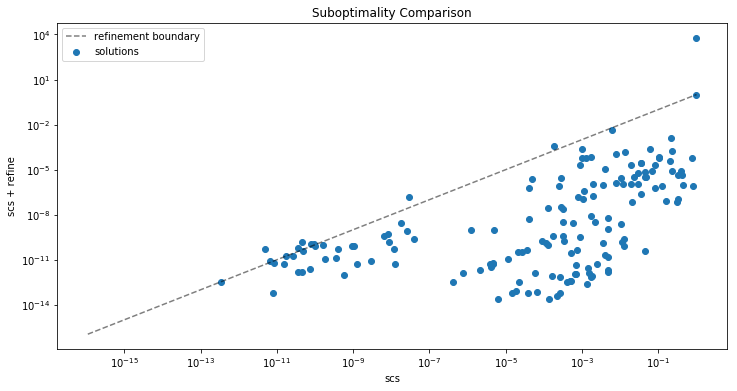

In [7]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

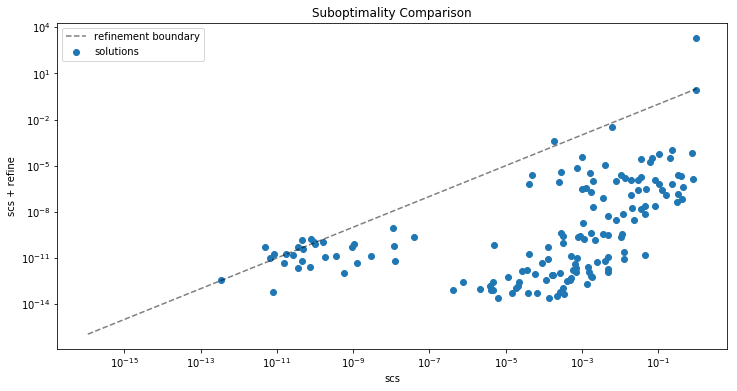

In [23]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

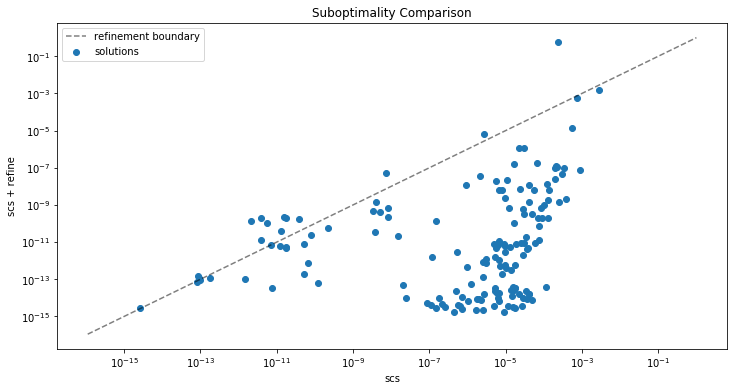

In [18]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

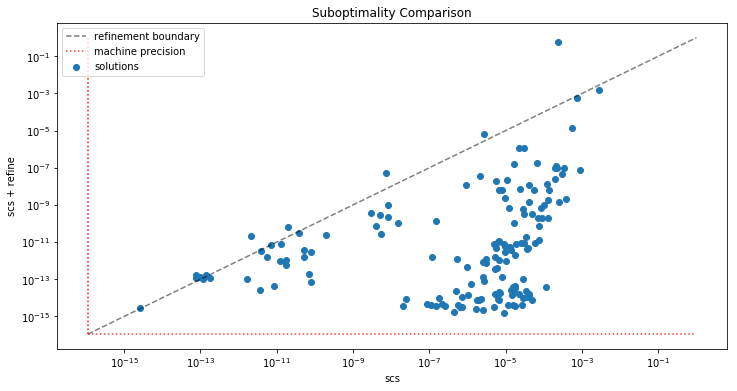

In [16]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

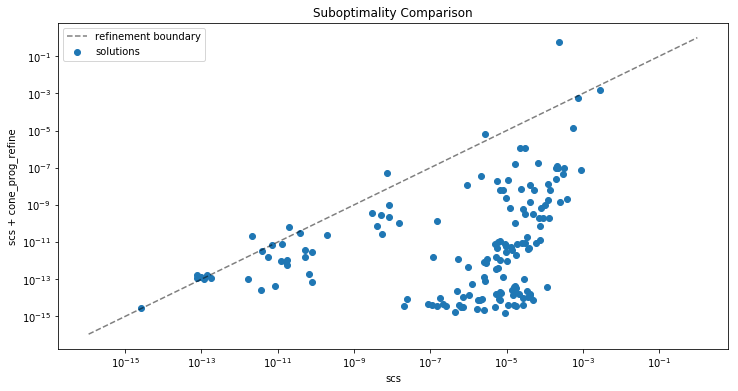

In [20]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + cone_prog_refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')


plt.legend(loc='upper left')
plt.savefig('comparison.png')

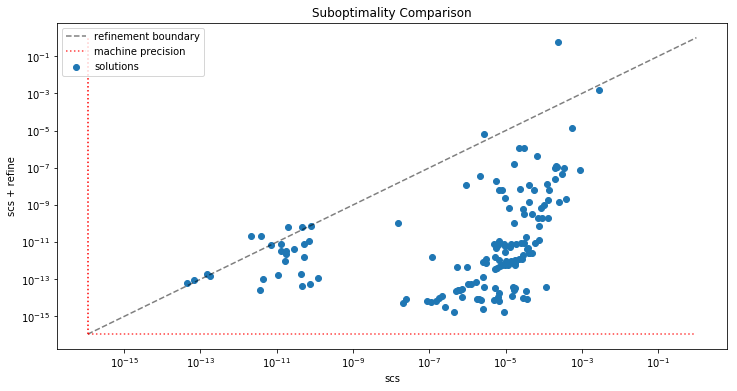

In [7]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

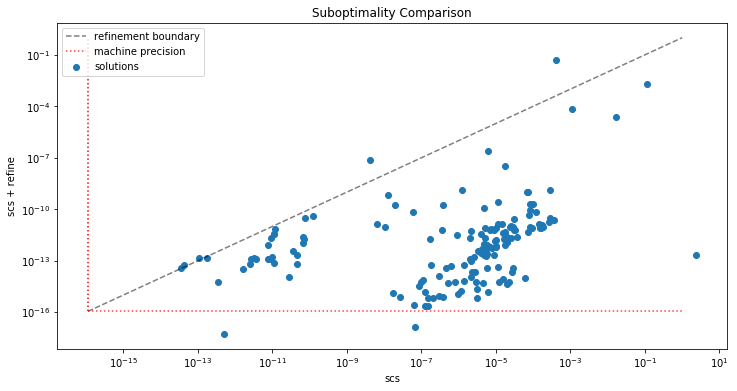

In [16]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

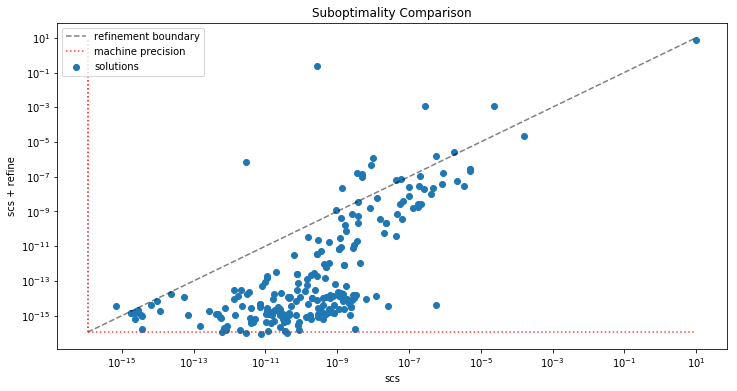

In [86]:
largest = max(max(scs_subopts), max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,largest],[EPS,largest], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,largest],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, largest], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

## Big-ass SDP 

In [ ]:
# dim_dict = {'s':[100]}

# np.random.seed(0)


# for con_subopt, scs_subopt, conico_time, scs_time in compare(dim_dict, 
#                                                              scs_presolve_iters = 5000,
#                                                              scs_presolve_eps = 1e-11,
#                                                              n_scenarios = 1, 
#                                                              conico_scs_time_ratio=1.,
#                                                              max_lsqr_iters=5000,
#                                                              verbose=True):
#     print()
#     print('%.2e, %.2e, %.2f, %.2f' % (con_subopt, scs_subopt, conico_time, scs_time))
#     print

## SDP GENERATED BY CVXPY

In [11]:
import cvxpy as cvx

def gen_prob(n):
    np.random.seed(100)
    m = (n*4)//5
    Sigma = np.random.randn(m,n)
    Sigma = Sigma.T @ Sigma/n
    x = cvx.Variable(n)
    objective = cvx.Maximize(cvx.sum(x))
    constraints = [x >= 0, cvx.diag(x) << Sigma]
    cvxpy_problem = cvx.Problem(objective, constraints)
    data = cvxpy_problem.get_problem_data('SCS')
    A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']
    dims_dict = {}
    dims_dict['l'], dims_dict['s'] = int(dims.nonpos), list([int(el) for el in dims.psd])
    
    return cvxpy_problem, A, b, c, dims_dict

cvxpy_problem, A, b, c, dim_dict = gen_prob(100)


In [ ]:
cvxpy_problem.solve()

In [12]:
x_con, s_con, y_con, info = solve(A,b,c,dim_dict,
      max_lsqr_iters=100,
      refine_solver_time_ratio=1.,
      verbose=True,
     solver_options={'verbose':True, 'eps':1e-15, 'max_iters':1000})


----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-15, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 100, constraints m = 5150
Cones:	linear vars: 100
	sd vars: 5050, sd blks: 1
Setup time: 2.09e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.01e+00  6.26e+01  5.66e-01 -2.44e+02 -8.82e+02  0.00e+00  1.97e-02 
   100| 2.84e-05  2.04e-04  2.00e-04 -2.02e-04 -1.81e-06  7.64e-13  1.63e-01 
   200| 4.83e-08  3.60e-07  2.68e-07  2.68e-07 -8.79e-12  9.16e-13 

In [ ]:
cvxpy_problem.solve(verbose=True, solver='SCS', max_iters=5000)


data = cvxpy_problem.get_problem_data('SCS')

A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']

A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']
dims_dict = {}
dims_dict['l'], dims_dict['s'] = dims.nonpos, dims.psd

## LP 

In [ ]:
dim_dict = {'l':1500}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1, verbose=True)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('LP_convergence.png')


## SOCP

In [ ]:
dim_dict = {'l':1000, 'q':[10]*100}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('SOCP_convergence.png')






## SDP 

In [ ]:
dim_dict = {'s':[100]}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1)



In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('SDP_convergence.png')







## Old

In [ ]:
dim_dict = {'l':100, 'q':[10]*10}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 20)

plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
# l: 1000
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
# dim_dict = {'l':100}
# conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')